In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce

In [18]:
plt.style.use('ggplot')

In [19]:
pairs_list = [
    'EURUSD/EURUSD_H4 - EURUSD_H4',
    'AUDUSD/AUDUSD_H4 - AUDUSD_H4',
    'GBPUSD/GBPUSD_H4 - GBPUSD_H4',
    'NZDUSD/NZDUSD_H4 - NZDUSD_H4',
    'USDCAD/USDCAD_H4 - USDCAD_H4',
    'USDCHF/USDCHF_H4 - USDCHF_H4',
    'USDJPY/USDJPY_H4 - USDJPY_H4',
    'XAUUSD/XAUUSD_H4 - XAUUSD_H4',
]
  

In [20]:
df ={}
for pair in range(len(pairs_list)) :
    df[pair] = pd.read_csv('../../Data_Forex/'+pairs_list[pair]+'.csv',index_col=0,parse_dates=True)

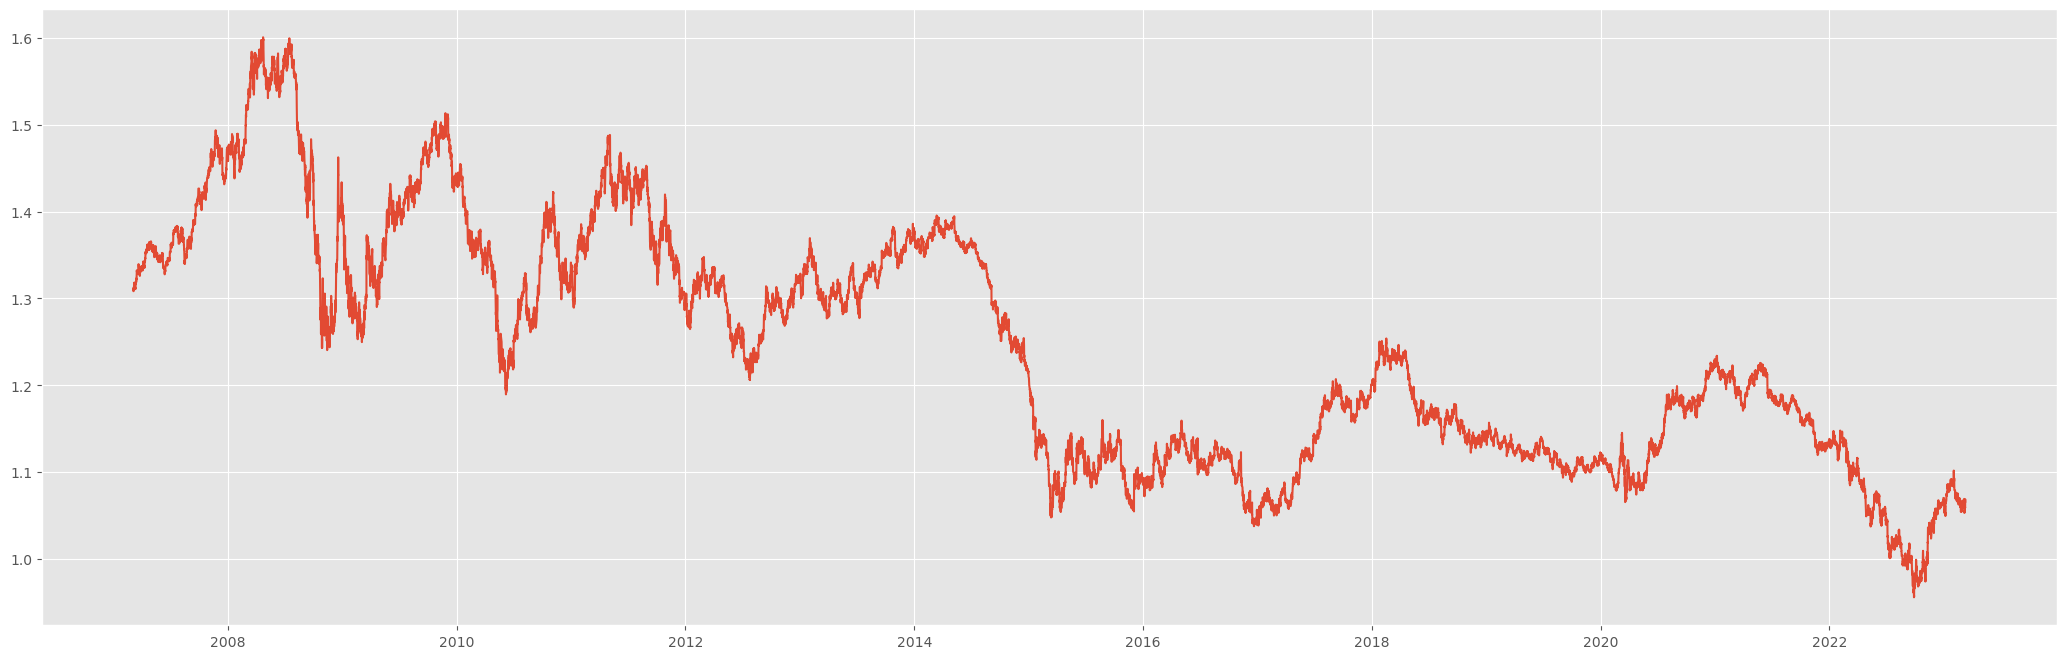

In [21]:
plt.figure(figsize = (26, 8))
plt.plot(df[0]['Close'])

In [22]:
#Strategy parameters
account_size = 1000
slippage = 2
size = 1
ATR_SL = 0.5

In [23]:
def SMA(df, fast, slow):
    df['sma_fast'] = df['Close'].rolling(fast).mean()
    df['sma_slow'] = df['Close'].rolling(slow).mean()
    return df

def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

def CAGR(df, source_df,TF):
    df = df.copy()
    n = (len(source_df)*TF) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)

def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)

In [24]:


for pair in range(len(pairs_list)):
    df[pair]['ATR'] = ATR(df[pair], 20)['ATR']
    df[pair]['sma_fast'] = SMA(df[pair], 50, 200)['sma_fast']
    df[pair]['inside_bar'] = np.where(((df[pair]['High'] < df[pair]['High'].shift(1)) & (df[pair]['Low'] > df[pair]['Low'].shift(1))), True, False)
    if 'USDJPY/USDJPY_H4 - USDJPY_H4'  not in pairs_list[pair] and 'XAUUSD/XAUUSD_H4 - XAUUSD_H4'  not in pairs_list[pair] :
        df[pair]['spread'] = float(slippage) / float(10000)
        df[pair]['size'] = float(size) * float(10000)
        print('Pair: ', pairs_list[pair], 'a')

    
    else:
        df[pair]['spread'] = float(slippage) / float(100)
        df[pair]['size'] = float(size) * float(100)
        print('Pair: ', pairs_list[pair], 'b')

Pair:  EURUSD/EURUSD_H4 - EURUSD_H4 a
Pair:  AUDUSD/AUDUSD_H4 - AUDUSD_H4 a
Pair:  GBPUSD/GBPUSD_H4 - GBPUSD_H4 a
Pair:  NZDUSD/NZDUSD_H4 - NZDUSD_H4 a
Pair:  USDCAD/USDCAD_H4 - USDCAD_H4 a
Pair:  USDCHF/USDCHF_H4 - USDCHF_H4 a
Pair:  USDJPY/USDJPY_H4 - USDJPY_H4 b
Pair:  XAUUSD/XAUUSD_H4 - XAUUSD_H4 b


In [25]:
df[0]

,Open,High,Low,Close,Volume,ATR,sma_fast,sma_slow,inside_bar,spread,size
Time,,,,,,,,,,,
2007-03-05 12:00:00,1.30956,1.31145,1.30723,1.30979,185987,NaN,NaN,NaN,False,0.0002,10000.0
2007-03-05 16:00:00,1.30960,1.31112,1.30833,1.30981,1025327,NaN,NaN,NaN,True,0.0002,10000.0
2007-03-05 20:00:00,1.30979,1.30986,1.30782,1.30840,235967,NaN,NaN,NaN,False,0.0002,10000.0
2007-03-06 00:00:00,1.30813,1.31113,1.30798,1.31071,191415,NaN,NaN,NaN,False,0.0002,10000.0
2007-03-06 04:00:00,1.31078,1.31262,1.30923,1.31211,187099,NaN,NaN,NaN,False,0.0002,10000.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-10 00:00:00,1.05855,1.05993,1.05791,1.05967,62976,0.002701,1.060872,1.071393,False,0.0002,10000.0
2023-03-10 04:00:00,1.05967,1.06066,1.05809,1.05948,58412,0.002755,1.060877,1.071246,False,0.0002,10000.0
2023-03-10 08:00:00,1.05946,1.06036,1.05738,1.05894,86765,0.002823,1.060869,1.071092,False,0.0002,10000.0


In [26]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}

for pair in range(len(pairs_list)):
    open_trade[pair] = []
    trade[pair] = {}
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []
    
    for i in range(50, len(df[pair])):
        #Buy
        if df[pair]['inside_bar'][i - 2] == True and df[pair]['inside_bar'][i - 1] == True and df[pair]['sma_fast'][i - 1] >= df[pair]['sma_slow'][i - 1] \
            and df[pair]['Close'][i] > df[pair]['Open'][i] and len(open_trade[pair]) == 0:
            print(i, 'New Long trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                             'date_of_trade': df[pair].index[i],
                             'entry_price': df[pair]['Close'][i],
                             'signal': 'Buy',
                             'result': 0, 
                             'TP': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL,
                             'SL': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
        
        #Sell
        if df[pair]['inside_bar'][i - 2] == True and df[pair]['inside_bar'][i - 1] == True and df[pair]['sma_fast'][i - 1] <= df[pair]['sma_slow'][i - 1] \
            and df[pair]['Close'][i] < df[pair]['Open'][i] and len(open_trade[pair]) == 0:
            print(i, 'New Short trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                             'date_of_trade': df[pair].index[i],
                             'entry_price': df[pair]['Close'][i],
                             'signal': 'Sell',
                             'result': 0, 
                             'TP': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL,
                             'SL': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])
            
        #Exit trades---------------------------------------------------------------------------
        #Buy profit
        if any(y <= df[pair]['Close'][i] for y in long_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] >= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['TP'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Buy loss
        if any(y >= df[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['SL'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                        
        #Sell profit
        if any(y >= df[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['TP'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Sell loss
        if any(y <= df[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['SL'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Exit after time
        if len(open_trade[pair]) != 0:
            for j in open_trade[pair]:
                if (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    trade[pair][j].update({'result' : (df[pair]['Close'][i] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Long exited after 48 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    long_take_profit[pair].remove(trade[pair][j]['TP'])
                    long_stop_loss[pair].remove(trade[pair][j]['SL'])
                elif (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - df[pair]['Close'][i] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Short exited after 48 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    short_take_profit[pair].remove(trade[pair][j]['TP'])
                    short_stop_loss[pair].remove(trade[pair][j]['SL'])

536 New Long trade at price: 1.3614  On day: 2007-07-04 00:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
536 Long profit at price: 1.364 On day: 2007-07-05 04:00:00 With profit: 10.46 

597 New Long trade at price: 1.3794  On day: 2007-07-17 20:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
597 Long profit at price: 1.3823 On day: 2007-07-18 00:00:00 With profit: 7.865 

616 New Long trade at price: 1.3836  On day: 2007-07-22 20:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
616 Long loss at price: 1.3821 On day: 2007-07-23 04:00:00 With loss: -15.92 

740 New Short trade at price: 1.347  On day: 2007-08-19 20:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
740 Short loss at price: 1.3495 On day: 2007-08-20 04:00:00 With loss: -24.3925 

809 New Short trade at price: 1.3605  On day: 2007-09-04 00:00:00 Pair: EURUSD/EURUSD_H4 - EURUSD_H4
809 Short profit at price: 1.3585 On day: 2007-09-04 08:00:00 With profit: 16.285 

827 New Short trade at price: 1.3667  On day: 2007-09-07 00:00:00 Pair: EURUSD/EURUSD_H4 - 

In [27]:
pairs_results = {}
profits = {}
losses = {}
be = {}

for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    be[pair] = []
    
    pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
    pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
    pairs_results[pair].set_index('date_of_trade', inplace = True)
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size
    
    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
        be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''
        
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

C:\Users\Win10\AppData\Local\Temp\ipykernel_12176\518135374.py:22: FutureWarning: Passing 'suffixes' which cause duplicate columns {'cum_res_x', 'entry_price_x', 'result_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())
C:\Users\Win10\AppData\Local\Temp\ipykernel_12176\518135374.py:22: FutureWarning: Passing 'suffixes' which cause duplicate columns {'cum_res_x', 'entry_price_x', 'result_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())
C:\Users\Win10\AppData\Local\Temp\ipykernel_12176\518135374.py:22: FutureWarning: Passing 'suffixes' which cause duplicate columns {'cum_res_x', 'entry_price_x', 'result_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())


Text(0.5, 1.0, 'Returns of each pair')

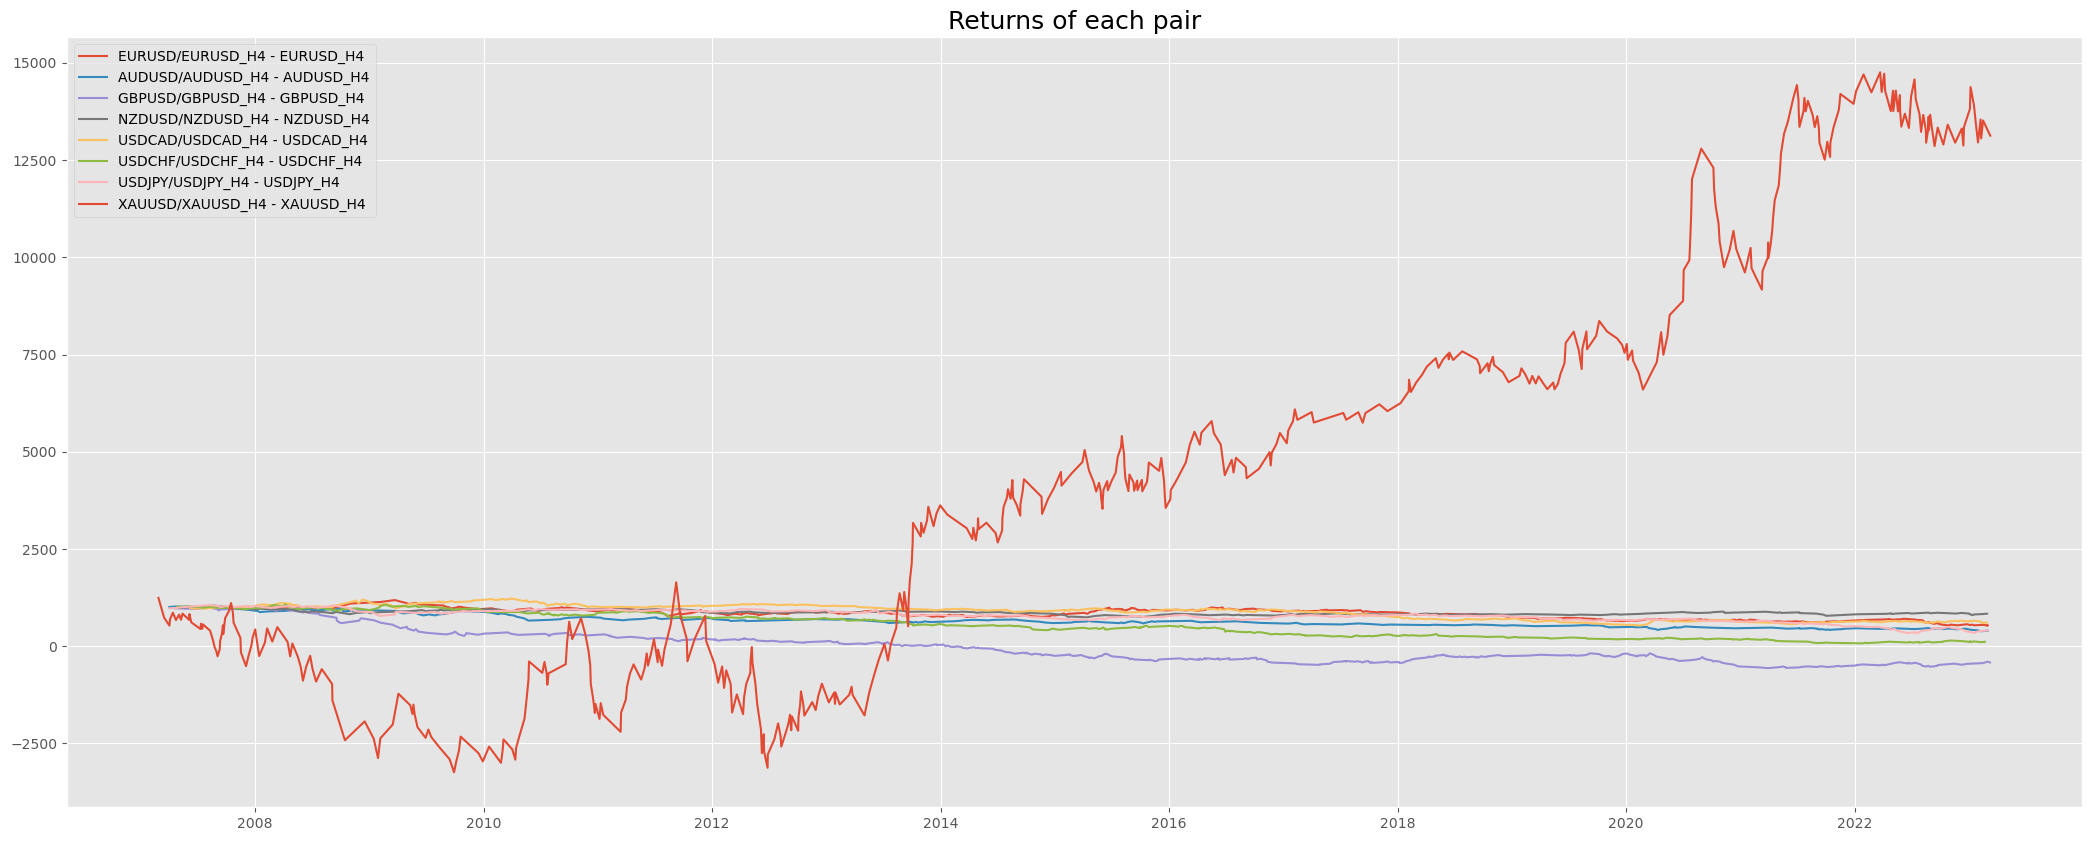

In [28]:
plt.figure(figsize = (26, 10))
for pair in range(len(pairs_list)):
    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize = 18)

In [29]:
strategy_results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2064 entries, 2007-02-25 20:00:00 to 2023-03-10 00:00:00
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   entry_price_x  401 non-null    float64
 1   result_x       401 non-null    float64
 2   cum_res_x      401 non-null    float64
 3   entry_price_y  234 non-null    float64
 4   result_y       234 non-null    float64
 5   cum_res_y      234 non-null    float64
 6   entry_price_x  398 non-null    float64
 7   result_x       398 non-null    float64
 8   cum_res_x      398 non-null    float64
 9   entry_price_y  199 non-null    float64
 10  result_y       199 non-null    float64
 11  cum_res_y      199 non-null    float64
 12  entry_price_x  347 non-null    float64
 13  result_x       347 non-null    float64
 14  cum_res_x      347 non-null    float64
 15  entry_price_y  389 non-null    float64
 16  result_y       389 non-null    float64
 17  cum_res_y      3

In [30]:
strategy_results['cum_res']

date_of_trade
2007-02-25 20:00:00    1242.7800
2007-03-08 00:00:00     958.5125
2007-03-16 00:00:00     735.1925
2007-04-01 20:00:00     514.6275
2007-04-04 00:00:00     679.3925
                         ...    
2023-02-27 00:00:00    8949.2525
2023-02-28 00:00:00    8957.6200
2023-03-02 00:00:00    9024.5525
2023-03-09 00:00:00    9003.4400
2023-03-10 00:00:00    8612.2450
Name: cum_res, Length: 2064, dtype: float64

***** STRATEGY PERFORMANCE *****
--------------------------------
CAGR: 13.4 %
Sharpe ratio: 0.0
Maximum drawdown 496.74 % 

Number of trades: 2778
Number of profits: 1424
Number of losses: 1354
Number of breakevens: 0 

Winning percentage 51.26 %
ROI: 7612
--------------------------------
Average profitable trade: 78.03
Average lossing trade: -76.44
Max profitable trade: 1072.74
Max lossing trade: -1027.92


c:\Users\Win10\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Text(0.5, 1.0, 'return of strategy')

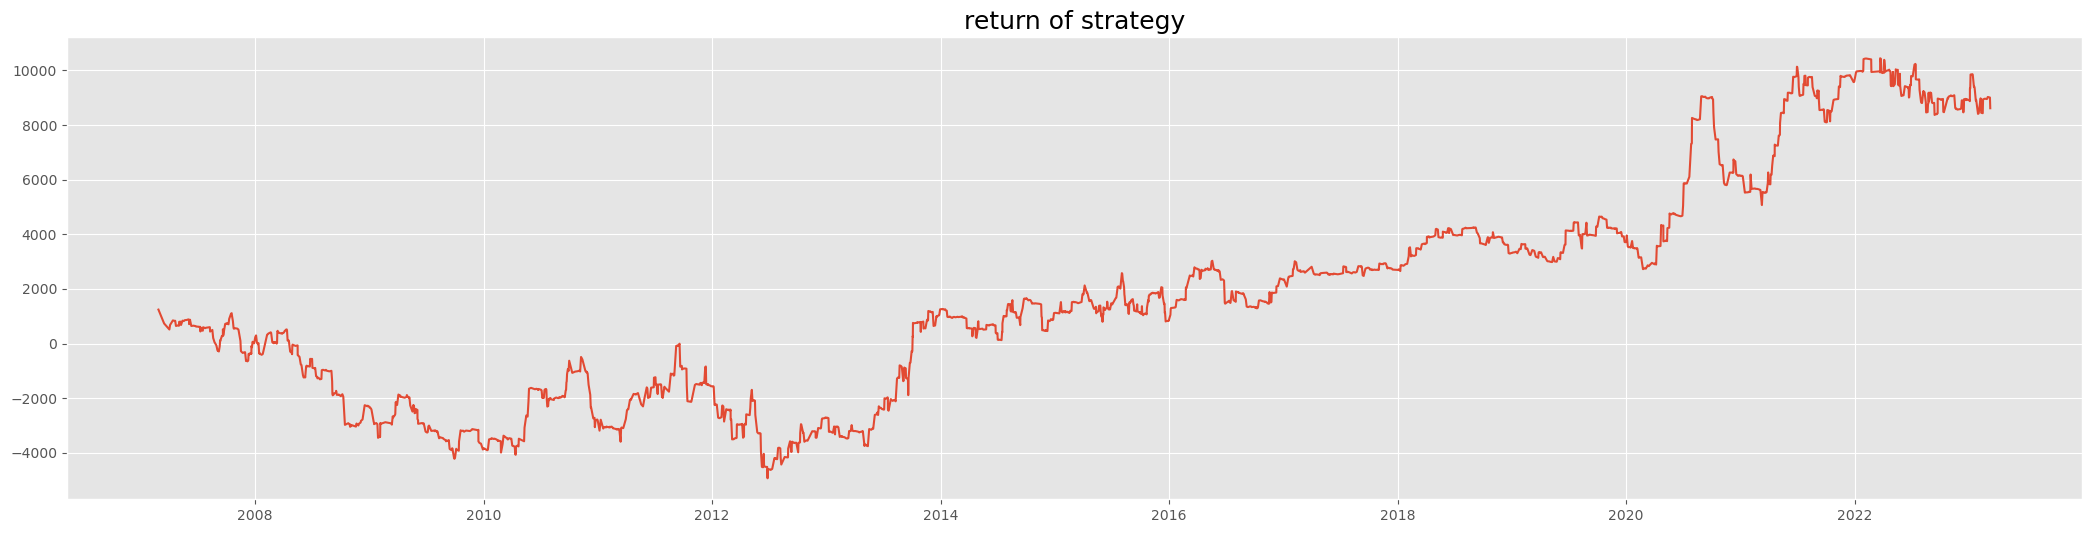

In [31]:
#Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df[0],4), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
print('Max profitable trade:', round(max(str_profits), 2))
print('Max lossing trade:', round(min(str_losses), 2))

plt.figure(figsize = (26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize = 18)